# Individual Household Electric Power Consumption Dataset from https://archive.ics.uci.edu/dataset/235/individual+household+electric+power+consumption

## Imports + Getting Data

In [5]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression as sklearn_linreg
from diffprivlib.models import LinearRegression as dp_linreg
import matplotlib.pyplot as plt
import timeit
import time

In [6]:
df = pd.read_csv("../../Data/household_power_consumption.txt", sep=";")
df.head()

/var/folders/j9/wckyp6gx05d8v6_3k06zgxr00000gn/T/ipykernel_22491/3898322139.py:1: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../../Data/household_power_consumption.txt", sep=";")


,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


## Pre-Processing

In [7]:
df = df.drop(["Date", "Time"], axis=1)
df = df.replace('?', np.nan)
df = df.apply(pd.to_numeric)
df = df.dropna()

In [8]:
# Split into Training and Testing Set
X = df.drop("Global_active_power", axis=1)
y = df["Global_active_power"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [9]:
# Normalize Dataset
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [10]:
X_with_bias = np.hstack((np.ones((X_test_scaled.shape[0], 1)), X_test_scaled))

## DP Linear Regression

In [11]:
# Get K Features with Highest Absolute Coefficients from Baseline Linear Regression
def getKBestFeatures(X_train_scaled, X_test_scaled, baseline_coefs, k):
    abs_baseline_coefs = np.absolute(baseline_coefs)
    ind = np.argpartition(abs_baseline_coefs, -k)[-k:]
    return pd.DataFrame(X_train_scaled).iloc[:, ind], pd.DataFrame(X_test_scaled).iloc[:, ind]

In [15]:
min_bounds_X = [-3 for _ in range(X_train_scaled.shape[1])]
max_bounds_X = [3 for _ in range(X_train_scaled.shape[1])]
bounds_X = (min_bounds_X, max_bounds_X)

# Baseline Linear Regression
lr = sklearn_linreg().fit(X_train_scaled, y_train)
lr_scores = cross_val_score(lr, X_test_scaled, y_test, cv=5, scoring='neg_mean_squared_error')

# Get RMSE
lr_err = np.mean(np.power(np.abs(lr_scores), 0.5))

In [16]:
ks = range(1, X_train_scaled.shape[1] + 1)
epsilons = [1, 5, 10]

base_lr_tax_surpluses = []
base_lr_errs = []

priv_lr_errors = [[] for _ in epsilons]
priv_lr_tax_surpluses = [[] for _ in epsilons]
lr_coef_distances = [[] for _ in epsilons]

for k in range(len(ks)):
    X_train_topk, X_test_topk = getKBestFeatures(X_train_scaled, X_test_scaled, lr.coef_, ks[k])

    min_bounds_X = [-3 for _ in range(k + 1)]
    max_bounds_X = [3 for _ in range(k + 1)]
    bounds_X = (min_bounds_X, max_bounds_X)

    base_lr = sklearn_linreg().fit(X_train_topk, y_train)
    base_lr_scores = cross_val_score(base_lr, X_test_topk, y_test, cv=5, scoring='neg_mean_squared_error')

    # Get RMSE
    base_lr_err = np.mean(np.power(np.abs(base_lr_scores), 0.5))
    base_lr_errs.append(base_lr_err)

    for e in range(len(epsilons)):
        priv_lr = dp_linreg(epsilon=epsilons[e], bounds_X=bounds_X, bounds_y=(0,12), random_state=42). fit(X_train_topk, y_train)
        priv_lr_scores = cross_val_score(priv_lr, X_test_topk, y_test, cv=5, scoring='neg_mean_squared_error')
        
        # Get RMSE
        priv_lr_errors[e].append(np.mean(np.power(np.abs(priv_lr_scores), 0.5)))

        # Get Coefficient Distances
        lr_coef_distances[e].append(np.linalg.norm(base_lr.coef_ - priv_lr.coef_))

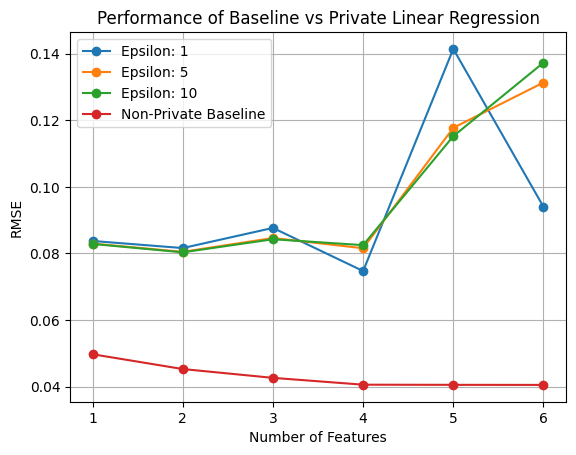

In [17]:
for e in range(len(epsilons)):
    plt.plot(ks, priv_lr_errors[e], '-o', label=f"Epsilon: {epsilons[e]}")

plt.plot(ks, base_lr_errs * np.ones_like(ks), '-o', label="Non-Private Baseline")
plt.xlabel("Number of Features")
plt.ylabel("RMSE")
plt.title("Performance of Baseline vs Private Linear Regression")
plt.grid(axis="both")
plt.legend();

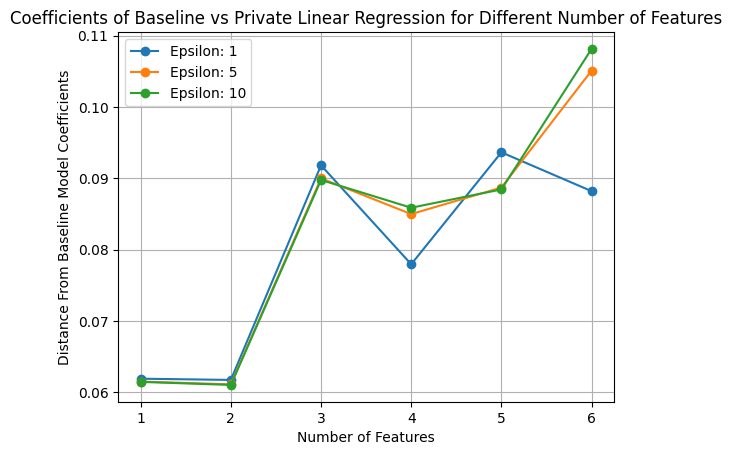

In [18]:
for e in range(len(epsilons)):
    plt.plot(ks, lr_coef_distances[e], '-o', label=f"Epsilon: {epsilons[e]}")

plt.xlabel("Number of Features")
plt.ylabel("Distance From Baseline Model Coefficients")
plt.title("Coefficients of Baseline vs Private Linear Regression for Different Number of Features")
plt.grid(axis="both")
plt.legend();

## Federated Learning

In [11]:
# Represent Federated Learning Using Mini-Batch SGD with Delay
def sgd(X, y, learning_rate, num_epochs, batch_size, delay_mean, delay_std, delay_min):
    start = timeit.default_timer()

    n_samples, n_features = X.shape
    num_batches = int(np.ceil(n_samples / batch_size))

    w = np.zeros(shape=(n_features + 1, 1))
    b = 0

    X_with_bias = np.hstack((np.ones((n_samples, 1)), X))
    
    for epoch in range(num_epochs):
        indices = np.random.permutation(n_samples)
        X_shuffled = X_with_bias[indices]
        y_shuffled = y.iloc[indices]
    
        for batch in range(num_batches):
            start_index = batch * batch_size
            end_index = min(start_index + batch_size, n_samples)

            X_batch = X_shuffled[start_index:end_index]
            y_batch = y_shuffled[start_index:end_index]
    
            predictions = np.dot(X_batch, w) + b
            predictions = predictions.reshape(predictions.shape[0], 1)
    
            errors = predictions - y_batch.values.reshape(-1, 1)
    
            w -= learning_rate * np.dot(X_batch.T, errors) / batch_size
            b -= learning_rate * np.mean(errors)

            delay = max(delay_min, np.random.normal(delay_mean, delay_std))
            time.sleep(delay)

    stop = timeit.default_timer()
    return w, b, stop - start

In [ ]:
# This took 22+ hours for me
observations = np.logspace(2, 6, 15)
baseline_errors = []
baseline_times = []
fl_errors = []
fl_times = []

for obs in observations:
    indices = np.random.permutation(range(int(obs)))
    X_train_indices = X_train_scaled[indices]
    y_train_indices = y_train.iloc[indices]

    baseline_weights, baseline_bias, baseline_time = sgd(X_train_indices, y_train_indices, learning_rate=0.01, num_epochs=10, batch_size=32, delay_mean=0, delay_std=0, delay_min=0)
    baseline_y_pred = np.dot(X_with_bias, baseline_weights) + baseline_bias
    baseline_errors.append(mean_squared_error(y_test, baseline_y_pred))
    baseline_times.append(baseline_time)

    # Delay: Mean 1ms, Std Dev 0.5ms, Min: 0.01ms
    fl_weights, fl_bias, fl_time = sgd(X_train_indices, y_train_indices, learning_rate=0.01, num_epochs=10, batch_size=1, delay_mean=0.001, delay_std=0.0005, delay_min=0.00001)
    fl_y_pred = np.dot(X_with_bias, fl_weights) + fl_bias
    fl_errors.append(mean_squared_error(y_test, fl_y_pred))
    fl_times.append(fl_time)

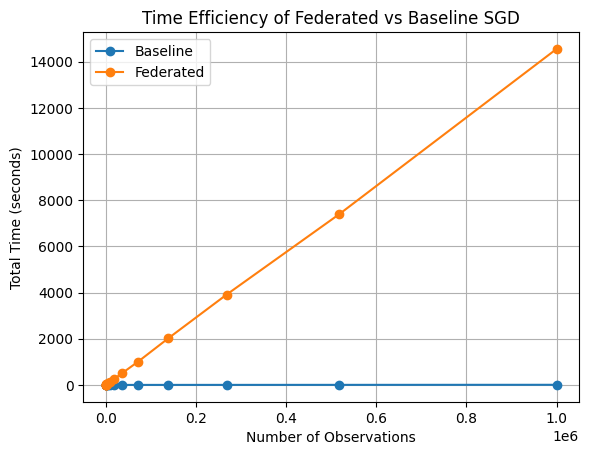

In [124]:
plt.plot(observations, baseline_times, '-o', label="Baseline")
plt.plot(observations, fl_times, '-o', label="Federated")
plt.xlabel("Number of Observations")
plt.ylabel("Total Time (seconds)")
plt.title("Time Efficiency of Federated vs Baseline SGD")
plt.grid(axis="both")
plt.legend();

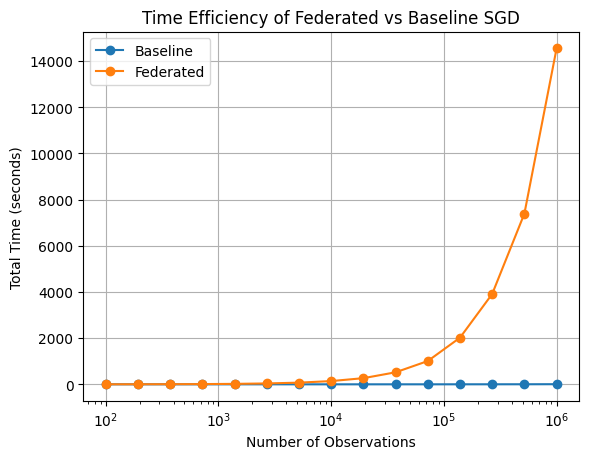

In [125]:
plt.plot(observations, baseline_times, '-o', label="Baseline")
plt.plot(observations, fl_times, '-o', label="Federated")
plt.xlabel("Number of Observations")
plt.ylabel("Total Time (seconds)")
plt.xscale("log")
plt.title("Time Efficiency of Federated vs Baseline SGD")
plt.grid(axis="both")
plt.legend();

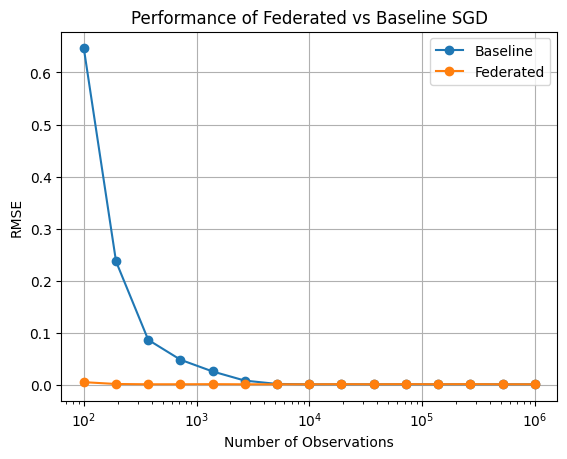

In [126]:
plt.plot(observations, baseline_errors, '-o', label="Baseline")
plt.plot(observations, fl_errors, '-o', label="Federated")
plt.xlabel("Number of Observations")
plt.ylabel("RMSE")
plt.xscale("log")
plt.title("Performance of Federated vs Baseline SGD")
plt.grid(axis="both")
plt.legend();

## Federated Learning + Differential Privacy

In [12]:
# Represent Federated Learning as DP Mini Batch SGD with Delay
def dp_sgd(X, y, learning_rate, num_epochs, batch_size, noise_scale, gradient_norm_bound, delay_mean, delay_std, delay_min):
    start = timeit.default_timer()

    n_samples, n_features = X.shape
    num_batches = int(np.ceil(n_samples / batch_size))

    w = np.zeros(shape=(n_features + 1, 1))
    b = 0

    X_with_bias = np.hstack((np.ones((n_samples, 1)), X))
    
    for epoch in range(num_epochs):
        indices = np.random.permutation(n_samples)
        X_shuffled = X_with_bias[indices]
        y_shuffled = y.iloc[indices]
    
        for batch in range(num_batches):
            start_index = batch * batch_size
            end_index = min(start_index + batch_size, n_samples)

            X_batch = X_shuffled[start_index:end_index]
            y_batch = y_shuffled[start_index:end_index]
    
            predictions = np.dot(X_batch, w) + b
            predictions = predictions.reshape(predictions.shape[0], 1)
    
            errors = predictions - y_batch.values.reshape(-1, 1)

            w_grad = np.dot(X_batch.T, errors) / batch_size
            b_grad = np.mean(errors)

            w_grad = clip_and_noise_gradient(w_grad, gradient_norm_bound, noise_scale)
            b_grad = clip_and_noise_gradient(b_grad, gradient_norm_bound, noise_scale)
    
            w -= learning_rate * w_grad
            b -= learning_rate * b_grad

            delay = max(delay_min, np.random.normal(delay_mean, delay_std))
            time.sleep(delay)

    stop = timeit.default_timer()
    return w, b, stop - start

def clip_and_noise_gradient(gradient, gradient_norm_bound, noise_scale):
    clipped = gradient / max(1, np.linalg.norm(gradient) / gradient_norm_bound)
    noisy = clipped + np.random.normal(0, (noise_scale ** 2) * (gradient_norm_bound ** 2), gradient.shape)
    return noisy

In [24]:
observations = [100, 1000, 10000, 50000]
baseline_errors = []
baseline_times = []
fl_errors = []
fl_times = []
noises = [0, 0.1, 1, 5]
norm_bounds = [0.01, 0.1, 1, 5]


for noise in noises:
    start_noise = timeit.default_timer()
    base_noise_errs = []
    base_noise_times = []
    fl_noise_errs = []
    fl_noise_times = []

    for bound in norm_bounds:
        base_bound_errs = []
        base_bound_times = []
        fl_bound_errs = []
        fl_bound_times = []
        
        for obs in observations:
            indices = np.random.permutation(range(int(obs)))
            X_train_indices = X_train_scaled[indices]
            y_train_indices = y_train.iloc[indices]

            baseline_weights, baseline_bias, baseline_time = sgd(X_train_indices, y_train_indices, learning_rate=0.01, num_epochs=10, batch_size=32, delay_mean=0, delay_std=0, delay_min=0)
            baseline_y_pred = np.dot(X_with_bias, baseline_weights) + baseline_bias
            base_bound_errs.append(mean_squared_error(y_test, baseline_y_pred))
            base_bound_times.append(baseline_time)

            # Delay: Mean 1ms, Std Dev 0.5ms, Min: 0.01ms
            fl_weights, fl_bias, fl_time = dp_sgd(X_train_indices, y_train_indices, learning_rate=0.01, num_epochs=10, batch_size=1, noise_scale=noise, gradient_norm_bound=bound, delay_mean=0.001, delay_std=0.0005, delay_min=0.00001)
            fl_y_pred = np.dot(X_with_bias, fl_weights) + fl_bias
            fl_bound_errs.append(mean_squared_error(y_test, fl_y_pred))
            fl_bound_times.append(fl_time)
        
        base_noise_errs.append(base_bound_errs)
        base_noise_times.append(base_bound_times)
        fl_noise_errs.append(fl_bound_errs)
        fl_noise_times.append(fl_bound_times)
    
    baseline_errors.append(base_noise_errs)
    baseline_times.append(base_noise_times)
    fl_errors.append(fl_noise_errs)
    fl_times.append(fl_noise_times)
    end_noise = timeit.default_timer()

Doing for 0 noise
	Duration: 69.55890728333227 minutes
Doing for 0.1 noise
	Duration: 66.5878055895834 minutes
Doing for 1 noise
	Duration: 69.59700737221671 minutes
Doing for 5 noise
	Duration: 65.22128857916687 minutes


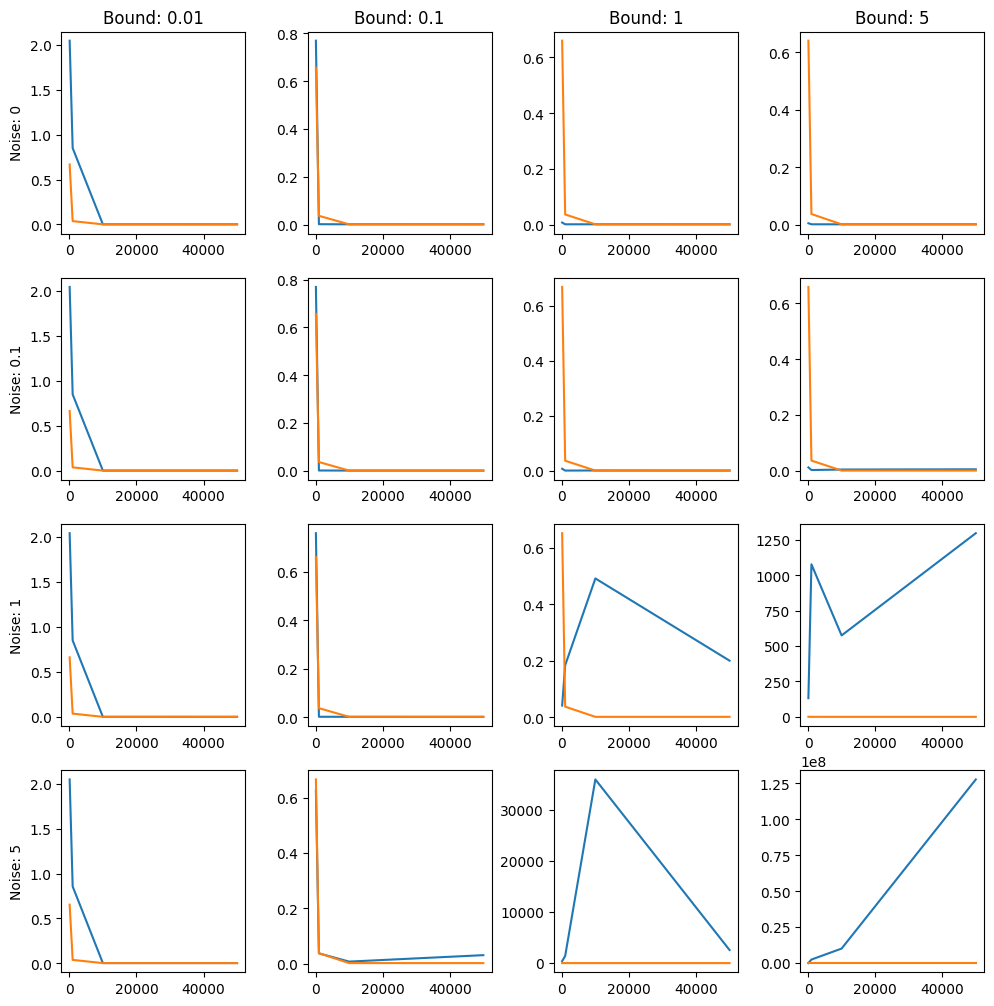

In [28]:
plt.title("Performance of FL+DP For Different Noise and Bound Combinations")
fig, axs = plt.subplots(nrows=len(noises), ncols=len(norm_bounds), figsize=(10, 10))
fig.tight_layout()

for ax_row in range(len(noises)):
    axs[ax_row, 0].set_ylabel(f"Noise: {noises[ax_row]}")

for ax_col in range(len(norm_bounds)):
    axs[0, ax_col].set_title(f"Bound: {norm_bounds[ax_col]}")

for ax_row in range(len(noises)):
    for ax_col in range(len(norm_bounds)):
        axs[ax_row, ax_col].plot(observations, fl_errors[ax_row][ax_col])
        axs[ax_row, ax_col].plot(observations, baseline_errors[ax_row][ax_col])

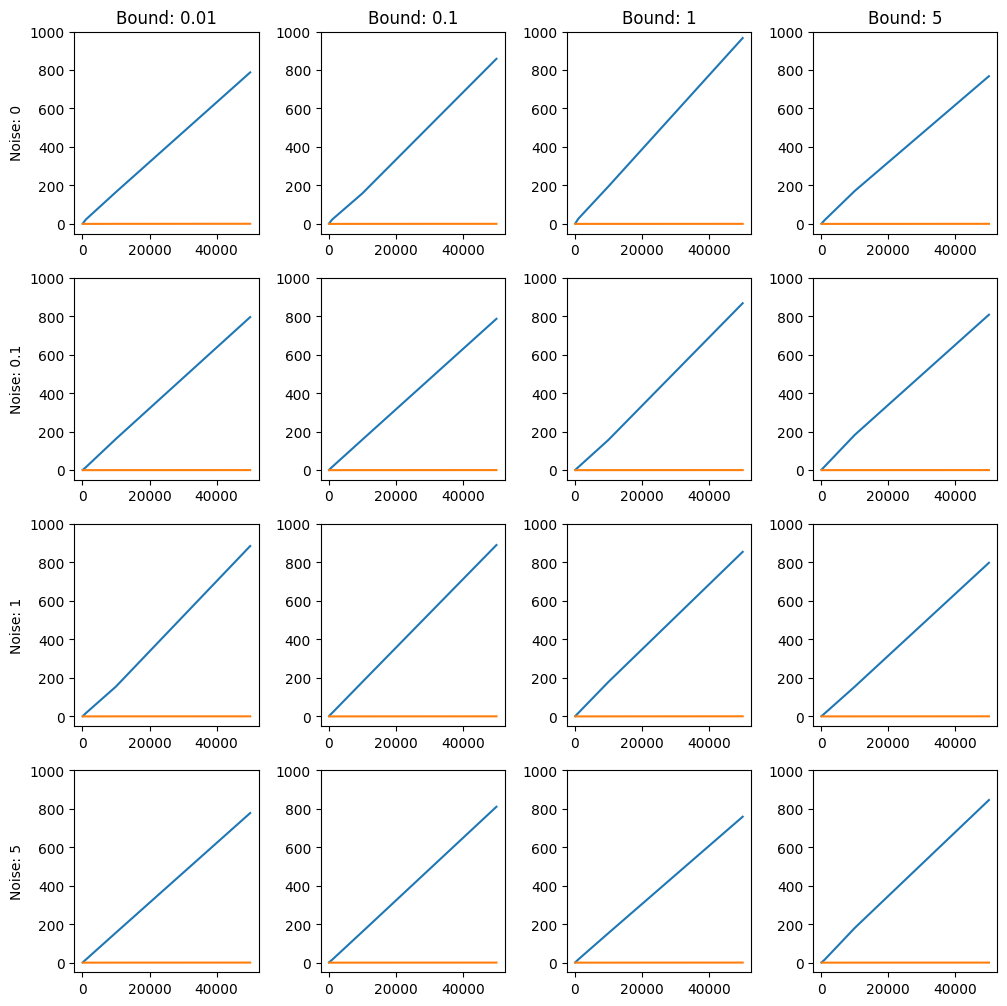

In [34]:
plt.title("Time Efficiency of FL+DP For Different Noise and Bound Combinations")
fig, axs = plt.subplots(nrows=len(noises), ncols=len(norm_bounds), figsize=(10, 10))
fig.tight_layout()

for ax_row in range(len(noises)):
    axs[ax_row, 0].set_ylabel(f"Noise: {noises[ax_row]}")

for ax_col in range(len(norm_bounds)):
    axs[0, ax_col].set_title(f"Bound: {norm_bounds[ax_col]}")

for ax_row in range(len(noises)):
    for ax_col in range(len(norm_bounds)):
        axs[ax_row, ax_col].plot(observations, fl_times[ax_row][ax_col])
        axs[ax_row, ax_col].plot(observations, baseline_times[ax_row][ax_col])
        axs[ax_row, ax_col].set_ylim([-50, 1000])